#### Importing library

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

#### Load and Preprocess Data

In [ ]:
file_path = 'GOOG.csv'
data = pd.read_csv(file_path)
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Filtering data till 2020 -> pre pandemic
data = data[data['Date'].dt.year <= 2020]

# Extracting target and train, test val dataset
values = data['Close'].values.astype('float32').reshape(-1, 1)
train_size = int(len(values) * 0.7)
val_size = int(len(values) * 0.15)
test_size = len(values) - train_size - val_size

train_data, val_data, test_data = np.split(values, [train_size, train_size + val_size])

# Scaling Data, fitting on Train Data
scaler = MinMaxScaler()
scaler.fit(train_data)

train_data_scaled = scaler.transform(train_data).flatten()
val_data_scaled = scaler.transform(val_data).flatten()
test_data_scaled = scaler.transform(test_data).flatten()

#### Dataset class

In [ ]:
# Defining  and calling the dataset for time series
class TimeSeriesDataset(Dataset):
    def __init__(self, data, sequence_length=30):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.sequence_length]
        y = self.data[idx + self.sequence_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
sequence_length = 30
train_dataset = TimeSeriesDataset(train_data_scaled, sequence_length)
val_dataset = TimeSeriesDataset(val_data_scaled, sequence_length)
test_dataset = TimeSeriesDataset(test_data_scaled, sequence_length)

#### Defining Model

In [ ]:
# Simple RNN Model
class SimpleRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

#### Trainning Evaluation and Plotting

Epoch [1/50], Train Loss: 0.0915, Val Loss: 0.5202
Epoch [2/50], Train Loss: 0.0168, Val Loss: 0.1094
Epoch [3/50], Train Loss: 0.0012, Val Loss: 0.0803
Epoch [4/50], Train Loss: 0.0007, Val Loss: 0.0598
Epoch [5/50], Train Loss: 0.0005, Val Loss: 0.0503
Epoch [6/50], Train Loss: 0.0004, Val Loss: 0.0391
Epoch [7/50], Train Loss: 0.0003, Val Loss: 0.0358
Epoch [8/50], Train Loss: 0.0003, Val Loss: 0.0304
Epoch [9/50], Train Loss: 0.0002, Val Loss: 0.0264
Epoch [10/50], Train Loss: 0.0002, Val Loss: 0.0237
Epoch [11/50], Train Loss: 0.0002, Val Loss: 0.0199
Epoch [12/50], Train Loss: 0.0002, Val Loss: 0.0176
Epoch [13/50], Train Loss: 0.0002, Val Loss: 0.0168
Epoch [14/50], Train Loss: 0.0002, Val Loss: 0.0146
Epoch [15/50], Train Loss: 0.0001, Val Loss: 0.0133
Epoch [16/50], Train Loss: 0.0001, Val Loss: 0.0113
Epoch [17/50], Train Loss: 0.0001, Val Loss: 0.0120
Epoch [18/50], Train Loss: 0.0001, Val Loss: 0.0129
Epoch [19/50], Train Loss: 0.0001, Val Loss: 0.0111
Epoch [20/50], Train 

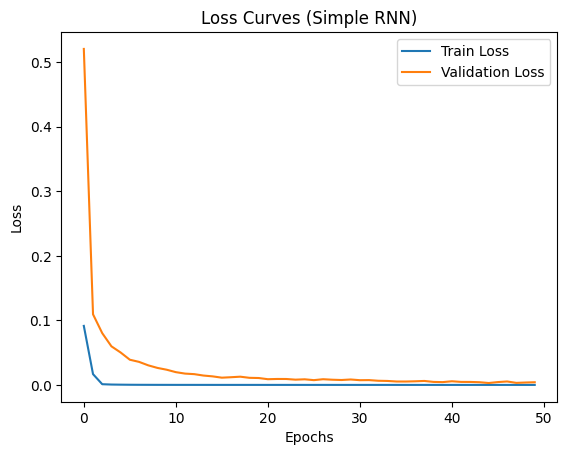

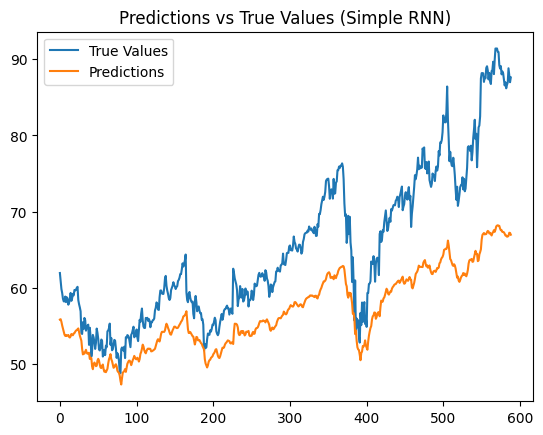

In [ ]:
# Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50):
    train_loss_list, val_loss_list = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for x, y in train_loader:
            x = x.unsqueeze(-1)  # shape: [batch, seq_len, 1]
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output.squeeze(), y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_loss = running_loss / len(train_loader)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val = x_val.unsqueeze(-1)
                val_output = model(x_val)
                val_loss = criterion(val_output.squeeze(), y_val)
                running_val_loss += val_loss.item()
        val_loss = running_val_loss / len(val_loader)
        val_loss_list.append(val_loss)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return train_loss_list, val_loss_list

def evaluate_model(model, test_loader):
    model.eval()
    predictions, targets = [], []
    with torch.no_grad():
        for x_test, y_test in test_loader:
            x_test = x_test.unsqueeze(-1)
            output = model(x_test)
            predictions.extend(output.squeeze().tolist())
            targets.extend(y_test.tolist())

    # Inverse transform
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    targets = scaler.inverse_transform(np.array(targets).reshape(-1, 1)).flatten()

    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(targets, predictions)
    return mse, mae, rmse, r2, predictions, targets

# Training
model = SimpleRNN(input_size=1, hidden_size=16, num_layers=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50)

mse, mae, rmse, r2, predictions, targets = evaluate_model(model, test_loader)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Plot loss curves
plt.figure()
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title("Loss Curves (Simple RNN)")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predictions vs targets
plt.figure()
plt.plot(targets, label='True Values')
plt.plot(predictions, label='Predictions')
plt.title("Predictions vs True Values (Simple RNN)")
plt.legend()
plt.show()